
## ML time series with sktime


In [1]:

## !pip install statsmodels


In [2]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



import warnings
warnings.filterwarnings('ignore')


In [45]:


import sktime
import statsmodels as sm
import matplotlib 
import sklearn

from sklearn.linear_model import( LinearRegression, 
                                 ElasticNet, 
                                 Ridge, 
                                 Lasso, 
                                 HuberRegressor)


from sktime.performance_metrics.forecasting import(MeanAbsolutePercentageError, 
                                                   MeanSquaredError, 
                                                   MeanAbsoluteScaledError)

from statsmodels.graphics.tsaplots import plot_acf



In [4]:

daily_temp = pd.read_csv('data/daily_weather.csv', 
                          index_col='DateTime', 
                          parse_dates=True
)

daily_temp.columns = ['y']

energy = pd.read_csv('data/energy_consumption.csv', 
                     index_col='Month', 
                     parse_dates=True
)

energy.columns = ['y']

air = pd.read_csv('data/air_passenger.csv', 
                  index_col='date', 
                  parse_dates=True)

air.columns = ['y']


In [5]:

daily_temp.index.freq = 'D'
energy.index.freq = 'MS'
air.index.freq = 'M'


In [6]:

print(daily_temp.index.freq)
print(energy.index.freq)
print(air.index.freq)


<Day>
<MonthBegin>
<MonthEnd>


<Axes: title={'center': 'Monthly Passengers'}, xlabel='date'>

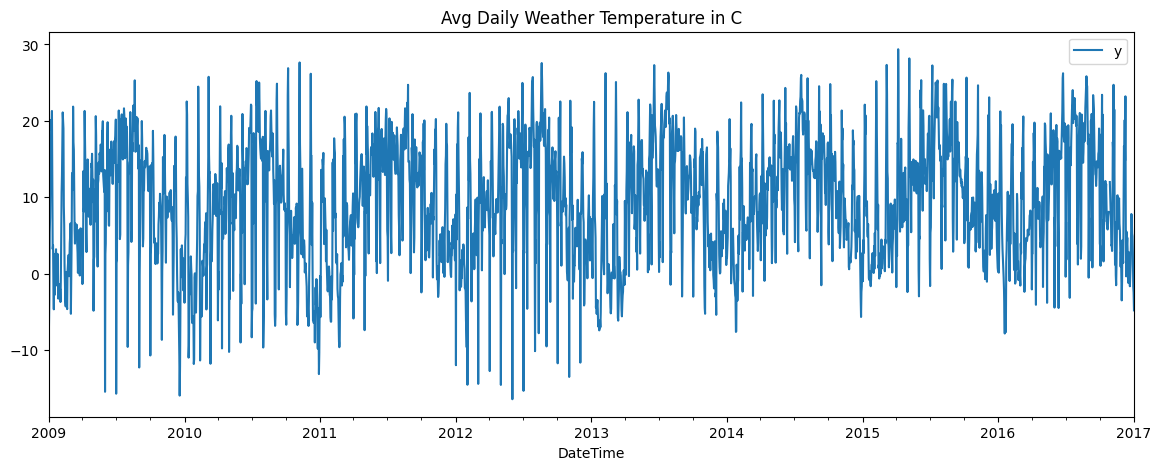

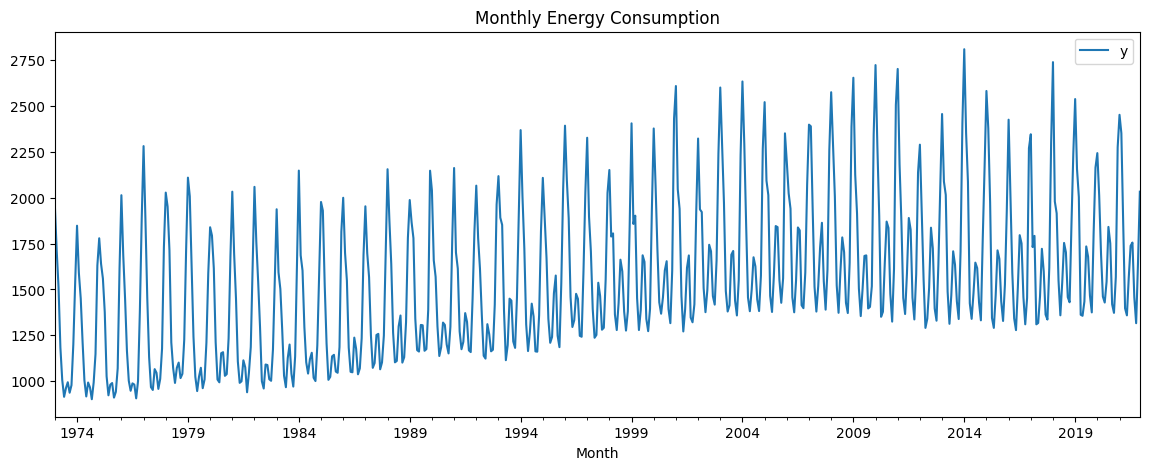

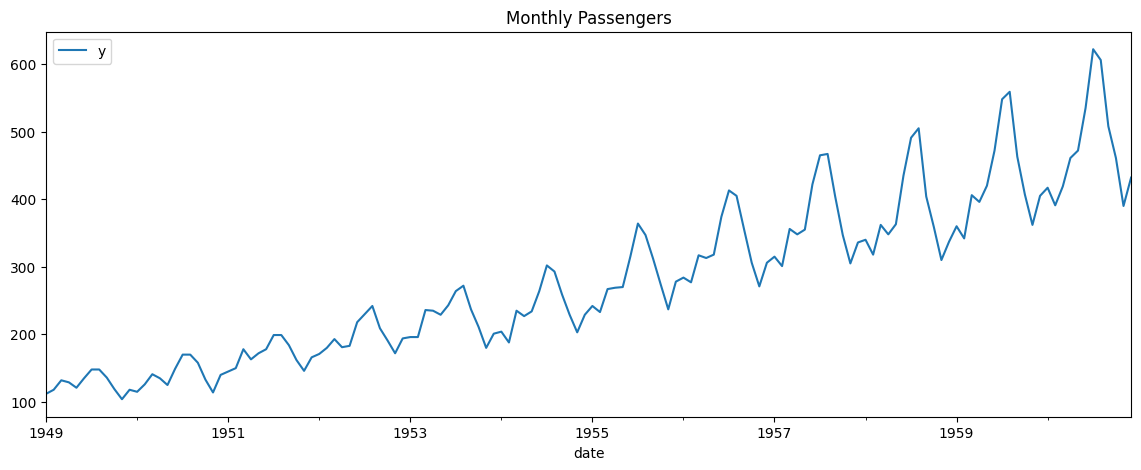

In [7]:

plt.rcParams["figure.figsize"] = [14, 5]  

daily_temp.plot(title='Avg Daily Weather Temperature in C')
energy.plot(    title='Monthly Energy Consumption')
air.plot(       title='Monthly Passengers')


In [8]:


daily_temp.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2923 entries, 2009-01-01 to 2017-01-01
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       2921 non-null   float64
dtypes: float64(1)
memory usage: 45.7 KB


In [9]:

energy.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 588 entries, 1973-01-01 to 2021-12-01
Freq: MS
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       588 non-null    float64
dtypes: float64(1)
memory usage: 9.2 KB


In [10]:

air.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-31 to 1960-12-31
Freq: M
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   y       144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


In [11]:

air_copy        = air.copy()
energy_copy     = energy.copy()
daily_temp_copy = daily_temp.copy()


In [12]:

def handle_missing_data(df):
    n = int(df.isna().sum())
    if n > 0:
        print(f'found {n} missing observations...')
        df.ffill(inplace=True)


In [13]:

for df in [air_copy, energy_copy, daily_temp_copy]:
    handle_missing_data(df)


found 2 missing observations...



## One step forecast with time window approach

* uses time window


In [20]:

def one_step_forecast(df, window):
    d = df.values
    x = []
    n = len(df)
    idx = df.index[:-window]
    for start in range(n-window):
        end = start + window
        x.append(d[start:end])
    cols = [f'x_{i}' for i in range(1, window+1)]
    x = np.array(x).reshape(n-window, -1)
    y = df.iloc[window:].values
    df_xs = pd.DataFrame(x, columns=cols, index=idx)
    df_y = pd.DataFrame(y.reshape(-1), columns=['y'], index=idx)
    return pd.concat([df_xs, df_y], axis=1).dropna()


In [21]:

air_os        = one_step_forecast(air_copy,        5)
energy_os     = one_step_forecast(energy_copy,     5)
daily_temp_os = one_step_forecast(daily_temp_copy, 5)

print(       air_os.shape)
print(    energy_os.shape)
print(daily_temp_os.shape)


(139, 6)
(583, 6)
(2918, 6)


In [22]:

air_os 


,x_1,x_2,x_3,x_4,x_5,y
date,,,,,,
1949-01-31,112,118,132,129,121,135
1949-02-28,118,132,129,121,135,148
1949-03-31,132,129,121,135,148,148
1949-04-30,129,121,135,148,148,136
1949-05-31,121,135,148,148,136,119
...,...,...,...,...,...,...
1960-03-31,419,461,472,535,622,606
1960-04-30,461,472,535,622,606,508
1960-05-31,472,535,622,606,508,461


In [23]:

def split_data(df, test_split=0.15):
    n = int(len(df) * test_split)
    train, test = df[:-n], df[-n:]
    return train, test


In [24]:

train, test = split_data(air_os)

print(f'Train: {len(train)} Test: {len(test)}')


Train: 119 Test: 20


In [25]:

class Standardize:
    def __init__(self, split=0.15):
        self.split = split
    
    def _transform(self, df):
        return (df - self.mu)/self.sigma
    
    def split_data(self, df):
        n = int(len(df) * test_split)
        train, test = df[:-n], df[-n:]
        return train, test
    
    def fit_transform(self, train, test):
        self.mu = train.mean()
        self.sigma = train.std()
        train_s = self._transform(train)
        test_s =  self._transform(test)
        return train_s, test_s

    def transform(self, df):
        return self._transform(df)
    
    def inverse(self, df):
        return (df * self.sigma)+self.mu
        
    def inverse_y(self, df):
        return (df * self.sigma[0])+self.mu[0]


In [26]:

scaler = Standardize()

train_s, test_s = scaler.fit_transform(train, test)

train_s.head()


,x_1,x_2,x_3,x_4,x_5,y
date,,,,,,
1949-01-31,-1.401933,-1.364908,-1.240908,-1.294771,-1.398791,-1.273682
1949-02-28,-1.338755,-1.216817,-1.272708,-1.379791,-1.250613,-1.136238
1949-03-31,-1.191342,-1.248551,-1.357508,-1.231006,-1.113020,-1.136238
1949-04-30,-1.222930,-1.333174,-1.209108,-1.092848,-1.113020,-1.263109
1949-05-31,-1.307167,-1.185083,-1.071309,-1.092848,-1.240029,-1.442843


In [27]:

y_train_original = scaler.inverse_y(train_s['y'])


In [28]:

train_original = scaler.inverse(train_s)
train_original.head()


,x_1,x_2,x_3,x_4,x_5,y
date,,,,,,
1949-01-31,112.0,118.0,132.0,129.0,121.0,135.0
1949-02-28,118.0,132.0,129.0,121.0,135.0,148.0
1949-03-31,132.0,129.0,121.0,135.0,148.0,148.0
1949-04-30,129.0,121.0,135.0,148.0,148.0,136.0
1949-05-31,121.0,135.0,148.0,148.0,136.0,119.0


In [30]:

air_cp = air.copy()
en_cp = energy.copy()
dw_cp = daily_temp.copy()


In [31]:

for df in [air_cp, en_cp, dw_cp]:
    handle_missing_data(df)


found 2 missing observations...


In [32]:

air_reg = one_step_forecast(air_cp, 10)
en_reg = one_step_forecast(en_cp, 10)
dw_reg = one_step_forecast(dw_cp, 10)


In [33]:

print(air_reg.shape)
print(en_reg.shape)
print(dw_reg.shape)


(134, 11)
(578, 11)
(2913, 11)


In [36]:

mse  = MeanSquaredError()
mape = MeanAbsolutePercentageError()
mase = MeanAbsoluteScaledError()


In [37]:

train_air, test_air = split_data(air_reg, test_split=0.10)
scaler_air = Standardize()
train_air_s, test_air_s = scaler_air.fit_transform(train_air,test_air)


In [38]:

train_en, test_en = split_data(en_reg, test_split=0.10)
scaler_en = Standardize()
train_en_s, test_en_s = scaler_en.fit_transform(train_en, test_en)


In [39]:

train_dw, test_dw = split_data(dw_reg, test_split=0.10)
scaler_dw = Standardize()
train_dw_s, test_dw_s = scaler_dw.fit_transform(train_dw,test_dw)


In [40]:

regressors = {
    'Linear Regression': LinearRegression(fit_intercept=False),
    'Elastic Net': ElasticNet(0.5, fit_intercept=False),
    'Ridge Regression': Ridge(0.5, fit_intercept=False),
    'Lasso Regression': Lasso(0.5, fit_intercept=False),
    'Huber Regression': HuberRegressor(fit_intercept=False)}


In [42]:

def train_model(train, test, regressor, reg_name):
    X_train, y_train  = train.drop(columns=['y']), train['y']
    X_test, y_test  = test.drop(columns=['y']), test['y']   

    print(f'training {reg_name} ...')
    
    regressor.fit(X_train, y_train) 
     
    yhat = regressor.predict(X_test)    
    rmse_test = np.sqrt(mse(y_test, yhat))
    mape_test = mape(y_test, yhat)
    mase_test = mase(y_test, yhat, y_train=y_train)    
    residuals = y_test.values - yhat     
    
    model_metadata = {
        'Model Name': reg_name, 'Model': regressor, 
        'RMSE': rmse_test, 'MAPE': mape_test, 'MASE': mase_test,
        'yhat': yhat, 'resid': residuals, 'actual': y_test.values}

    return model_metadata


In [43]:

def train_different_models(train, test, regressors):
    results = []
    for reg_name, regressor in regressors.items():
        results.append(train_model(train,
                                   test,
                                   regressor,
                                   reg_name))
    return results


In [44]:

air_results = train_different_models(train_air_s, test_air_s, regressors)
en_results = train_different_models(train_en_s, test_en_s, regressors)
dw_results = train_different_models(train_dw_s, test_dw_s, regressors)


training Linear Regression ...
training Elastic Net ...
training Ridge Regression ...
training Lasso Regression ...
training Huber Regression ...
training Linear Regression ...
training Elastic Net ...
training Ridge Regression ...
training Lasso Regression ...
training Huber Regression ...
training Linear Regression ...
training Elastic Net ...
training Ridge Regression ...
training Lasso Regression ...
training Huber Regression ...


In [46]:


def plot_results(cols, results, data_name):
    for row in results[cols].iterrows():
        yhat, resid, actual, name = row[1]
        plt.title(f'{data_name} - {name}')
        plt.plot(actual, 'k--', alpha=0.5)
        plt.plot(yhat, 'k')
        plt.legend(['actual', 'forecast'])
        plot_acf(resid, zero=False, 
                 title=f'{data_name} - Autocorrelation')
        plt.show()


In [47]:

cols = ['Model Name', 'RMSE', 'MAPE', 'MASE']
air_results = pd.DataFrame(air_results)
air_results[cols].sort_values('MASE')


,Model Name,RMSE,MAPE,MASE
2,Ridge Regression,0.381092,0.202191,1.390807
0,Linear Regression,0.385559,0.205371,1.411072
4,Huber Regression,0.400949,0.214912,1.457932
1,Elastic Net,0.829023,0.328472,2.808737
3,Lasso Regression,1.190006,0.551243,4.439302


In [48]:

cols = ['Model Name', 'RMSE', 'MAPE', 'MASE']
en_results = pd.DataFrame(en_results)
en_results[cols].sort_values('MASE')


,Model Name,RMSE,MAPE,MASE
4,Huber Regression,0.431651,1.419527,0.525526
2,Ridge Regression,0.433192,1.586383,0.560450
0,Linear Regression,0.433747,1.583406,0.560989
1,Elastic Net,0.747657,1.822362,1.013425
3,Lasso Regression,0.834356,1.548537,1.108092


In [49]:

cols = ['Model Name', 'RMSE', 'MAPE', 'MASE']
dw_results = pd.DataFrame(dw_results)
dw_results[cols].sort_values('MASE')


,Model Name,RMSE,MAPE,MASE
4,Huber Regression,0.655729,1.083826,0.968735
0,Linear Regression,0.646648,1.037424,0.990057
2,Ridge Regression,0.646639,1.037273,0.990085
1,Elastic Net,0.737896,0.913599,1.300792
3,Lasso Regression,0.814609,0.911730,1.468567


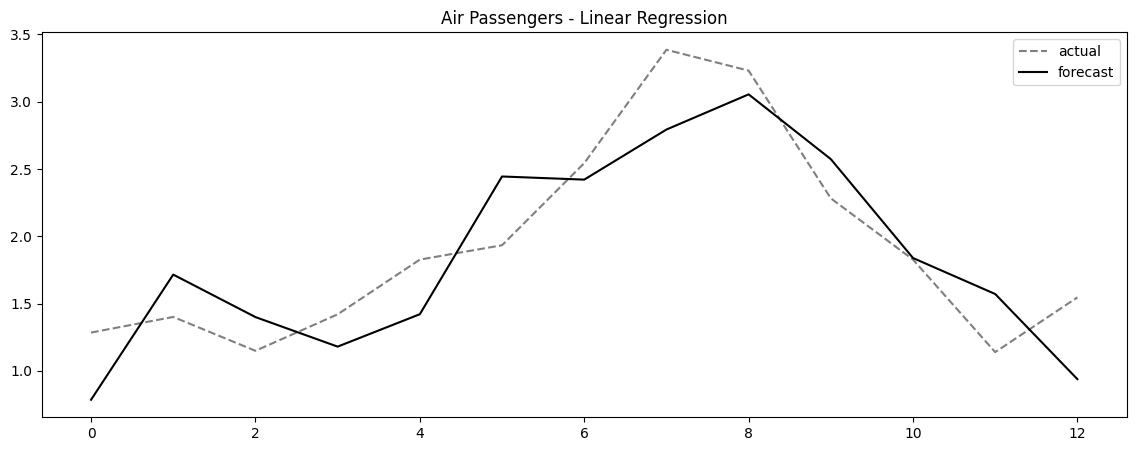

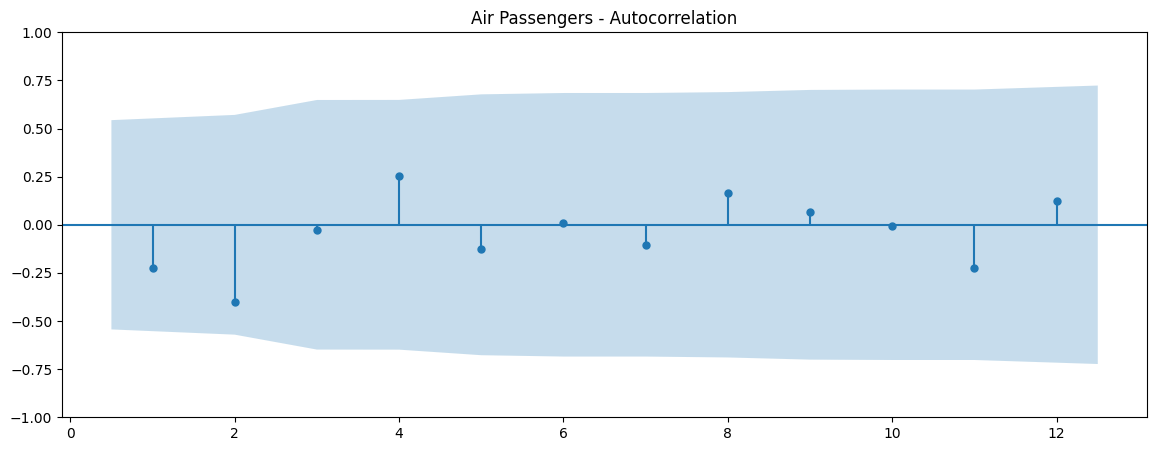

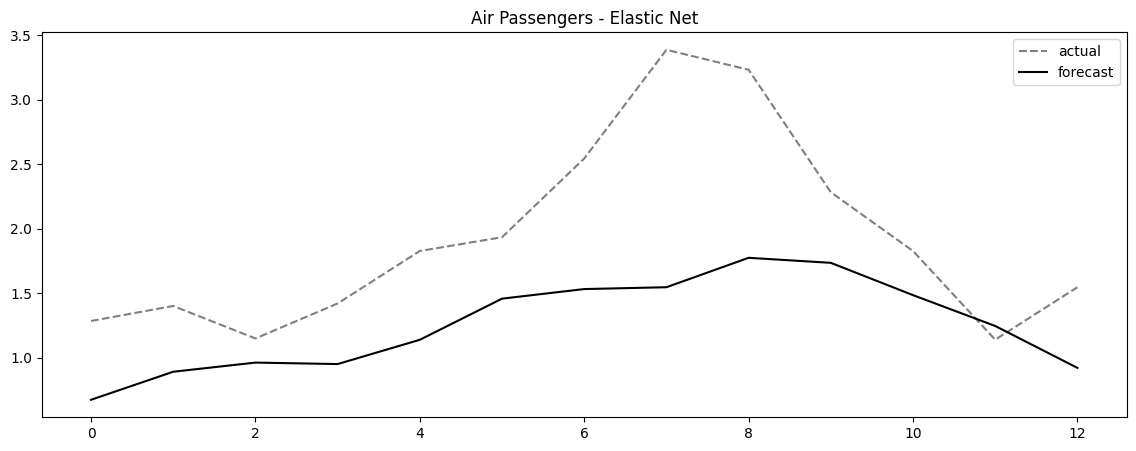

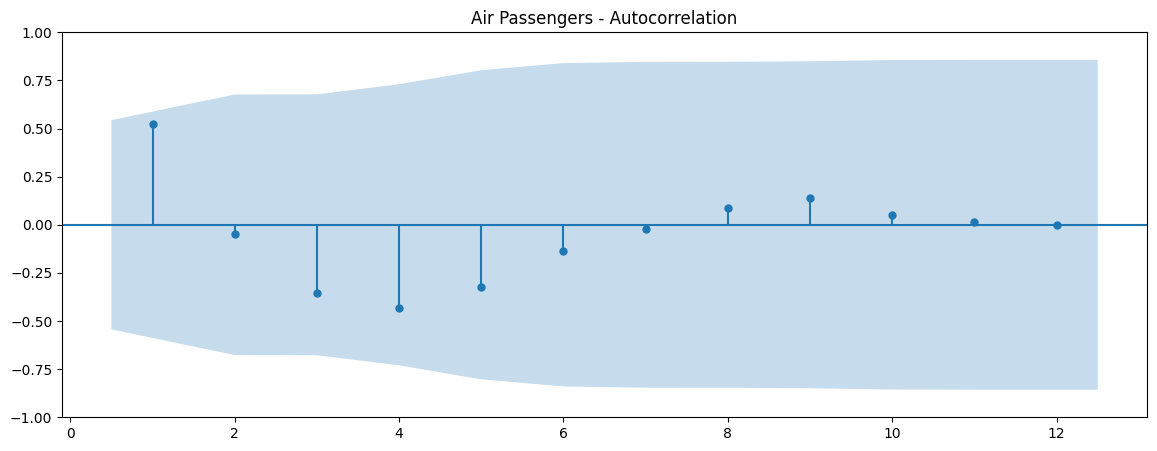

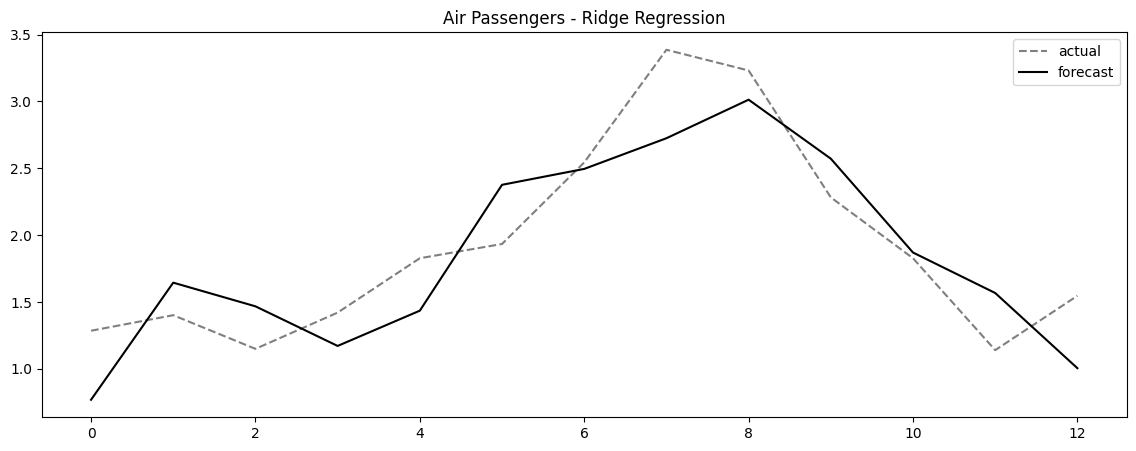

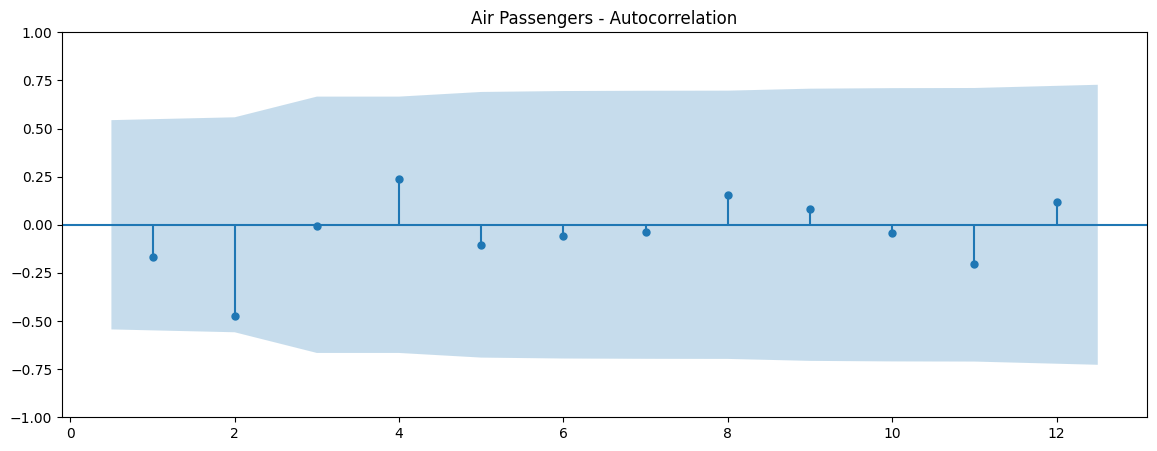

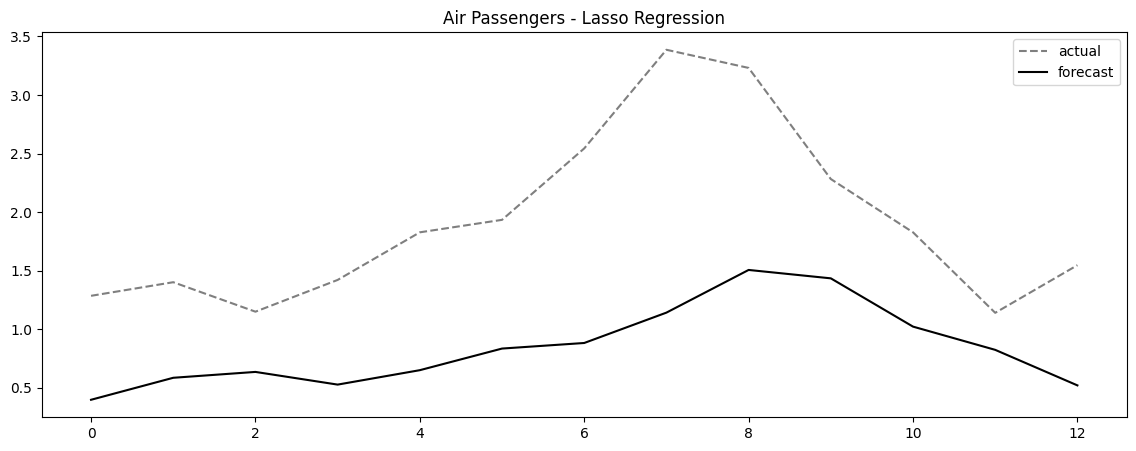

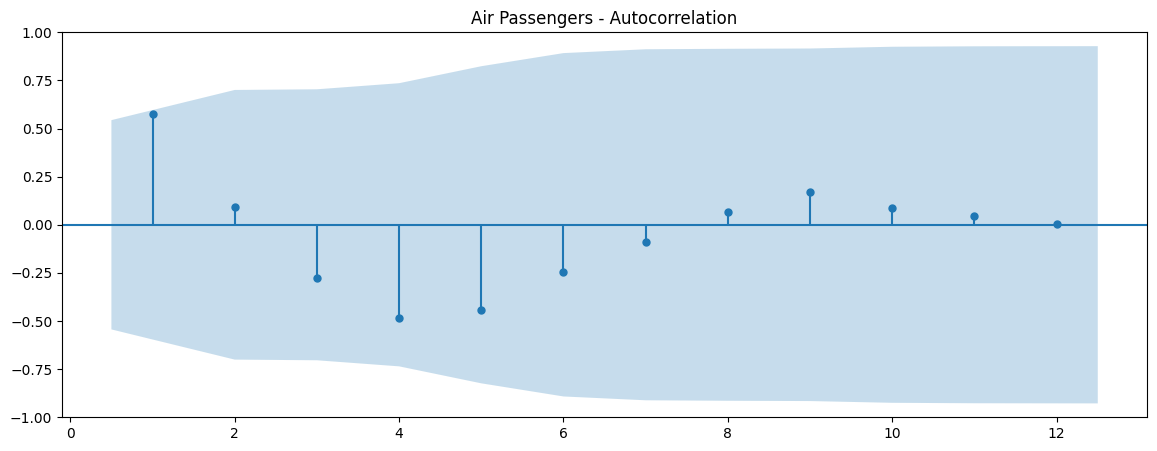

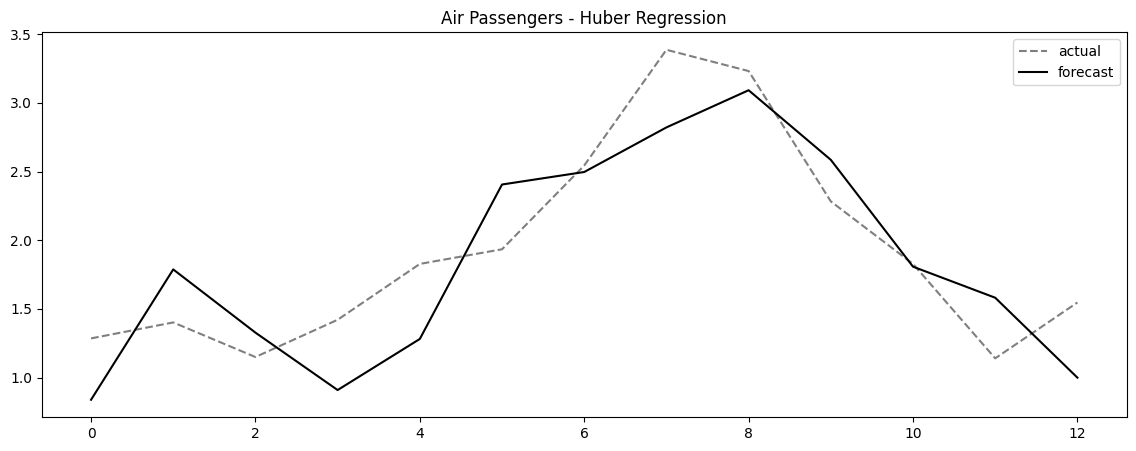

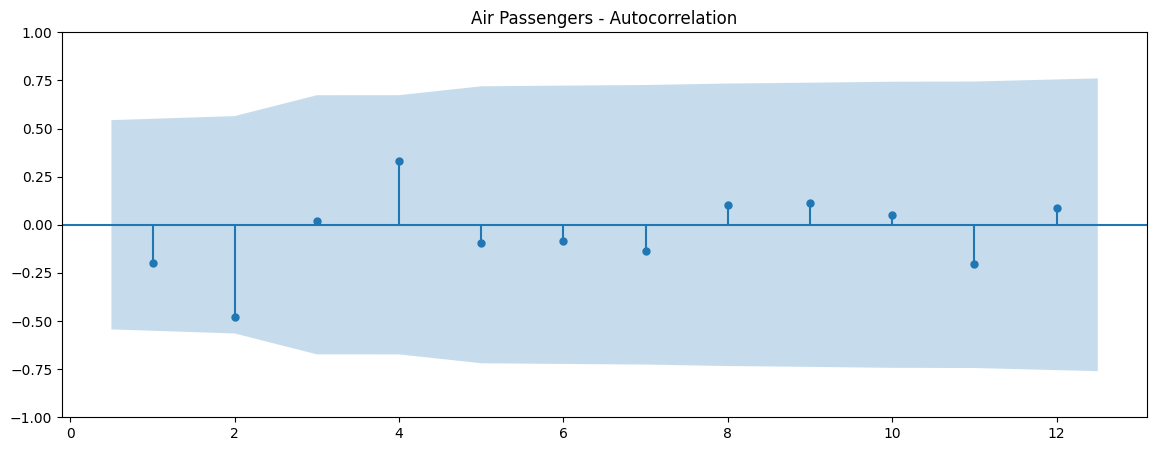

In [50]:

cols = ['yhat', 'resid', 'actual', 'Model Name']
plot_results(cols, air_results, 'Air Passengers')


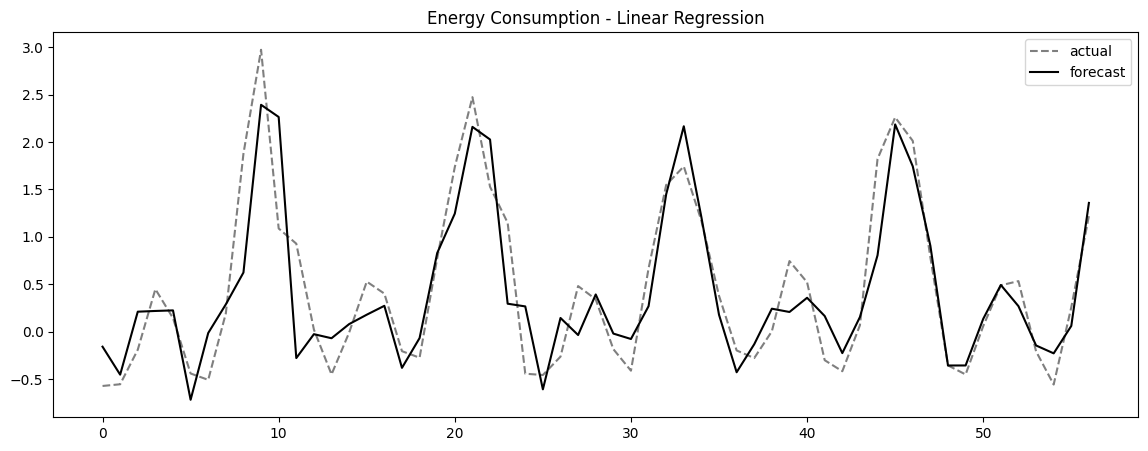

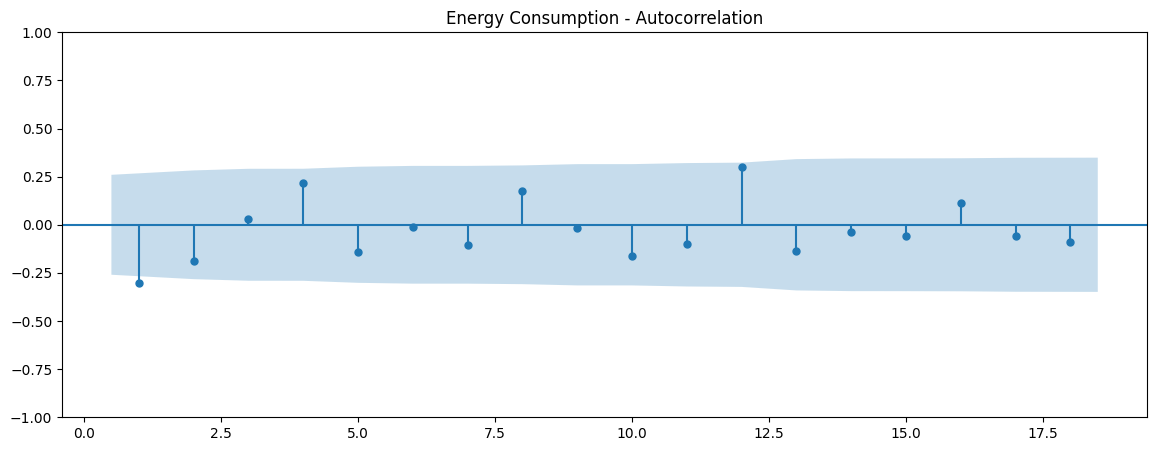

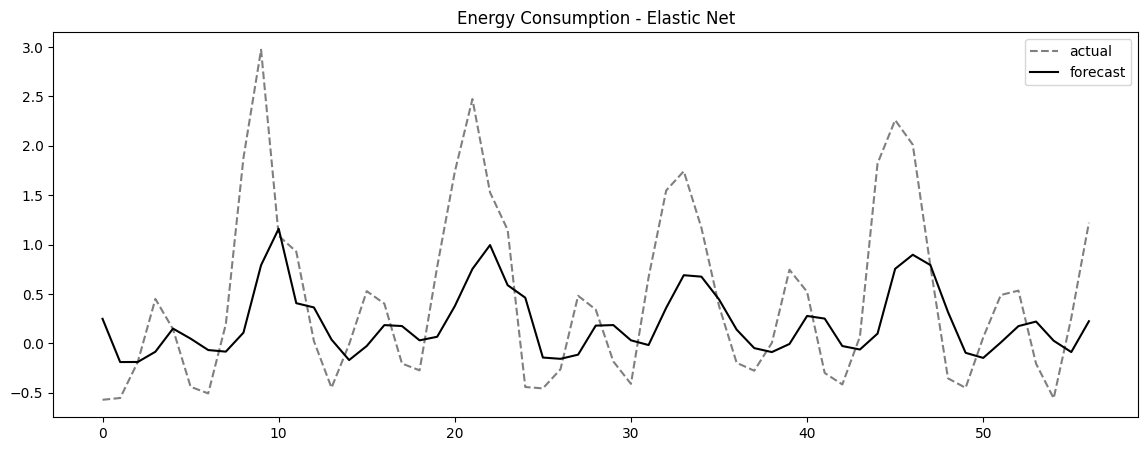

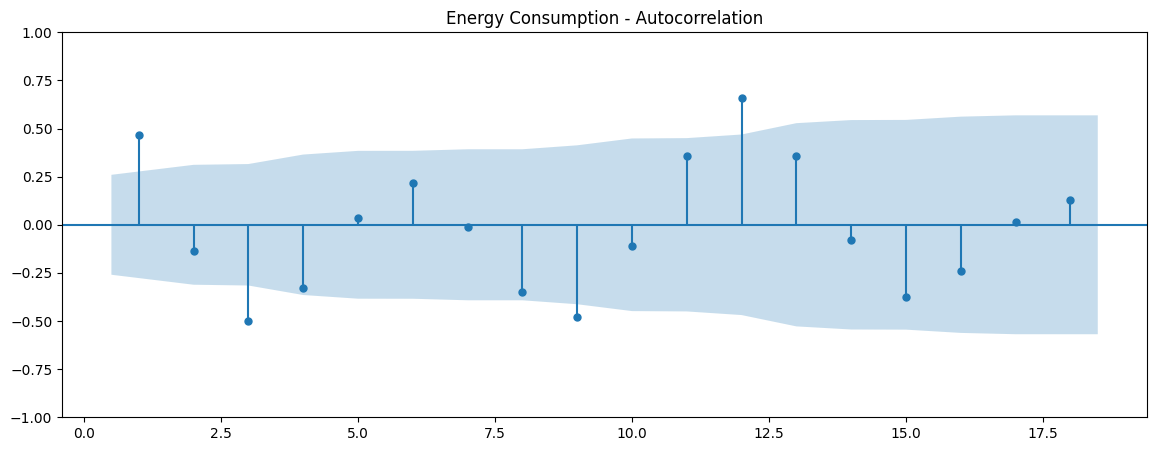

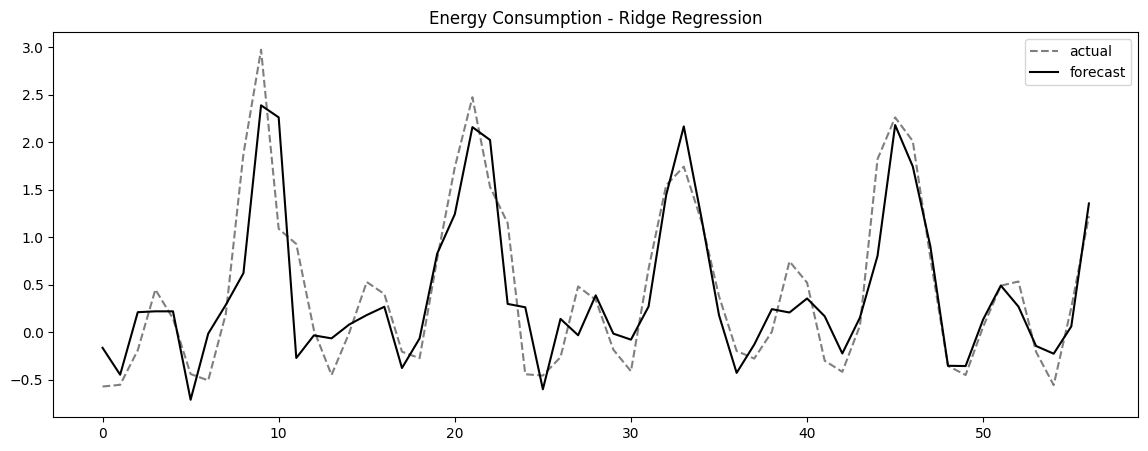

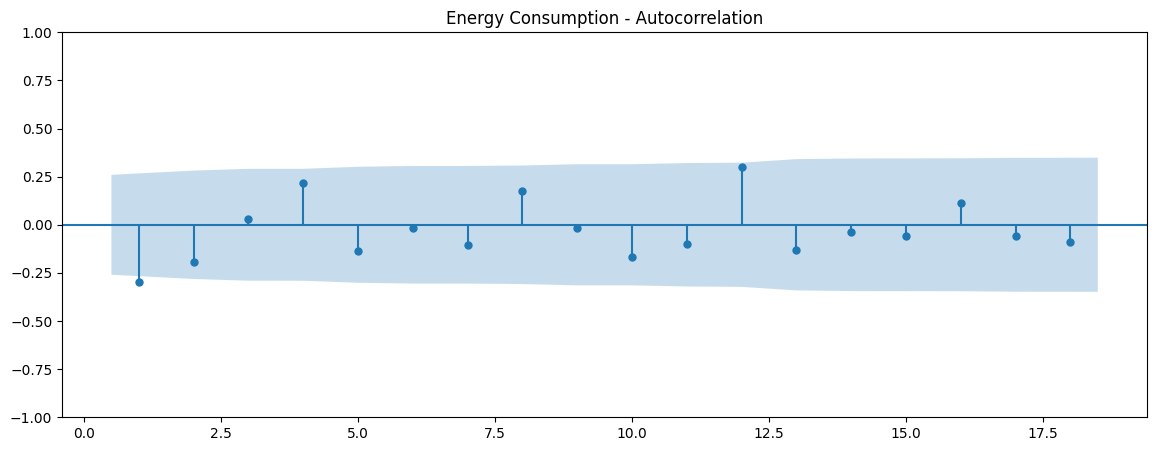

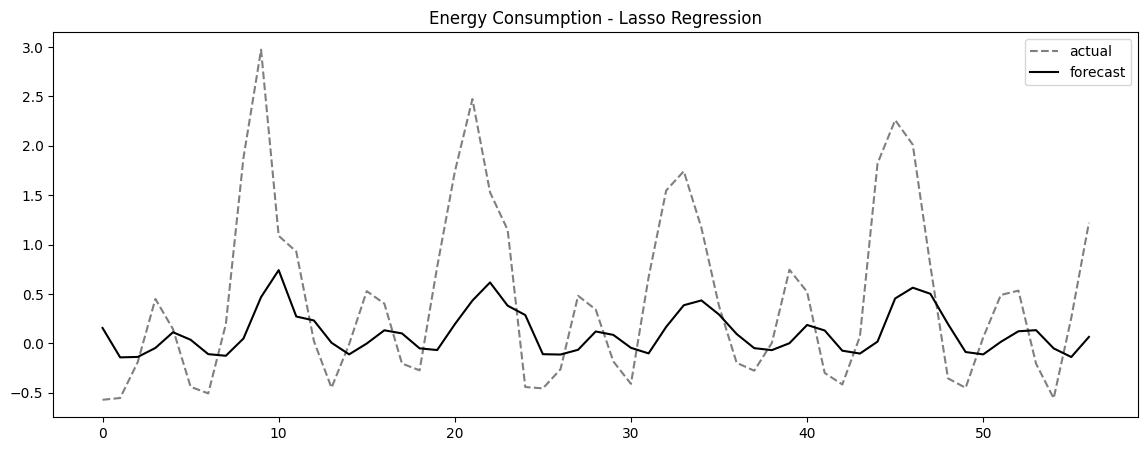

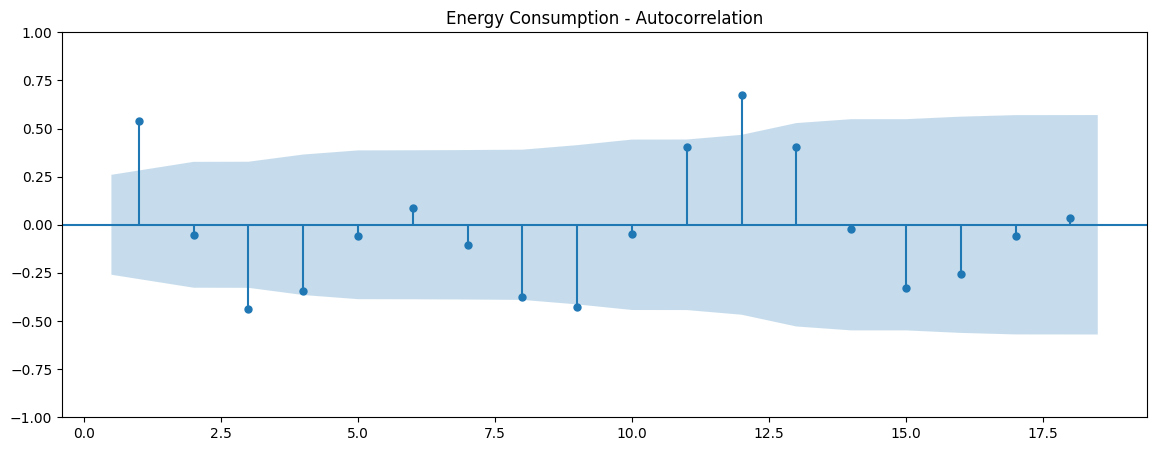

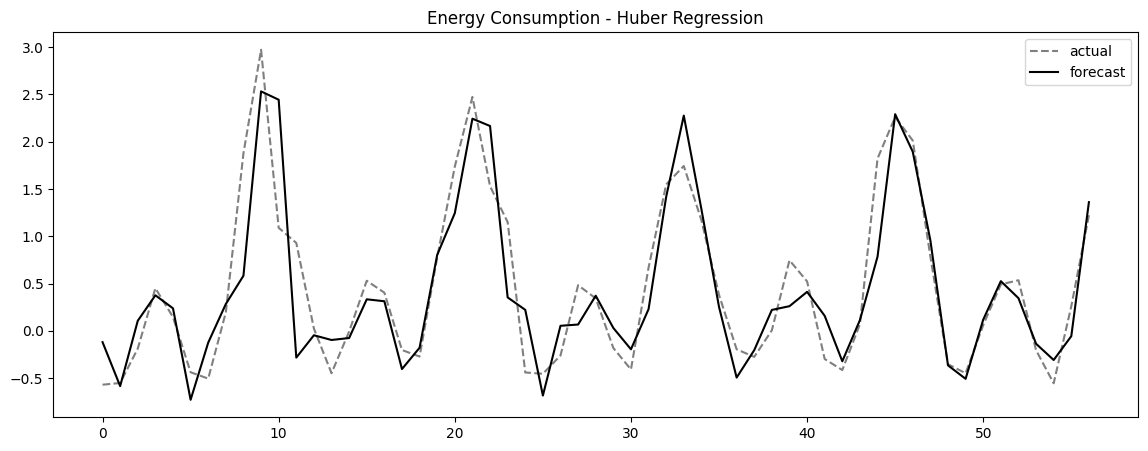

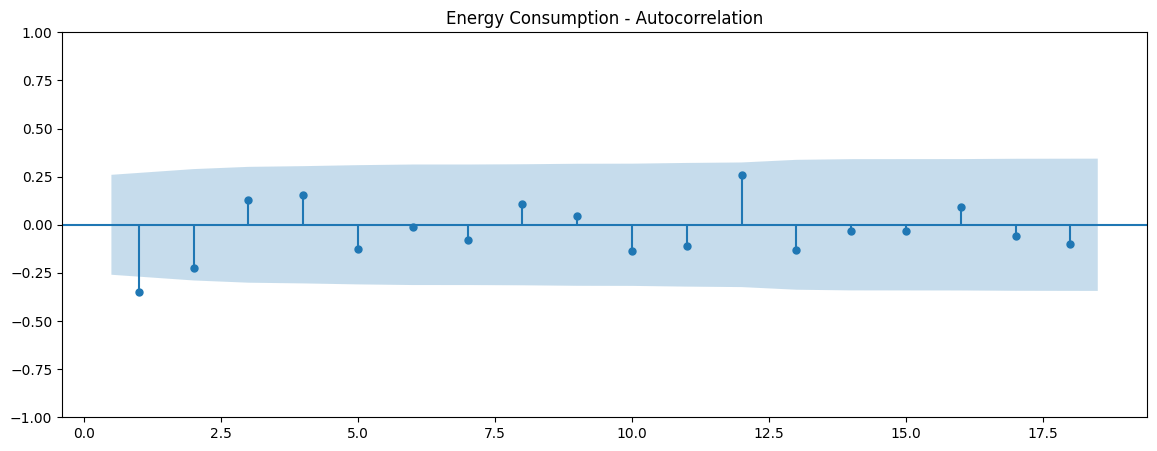

In [51]:

plot_results(cols, en_results, 'Energy Consumption')


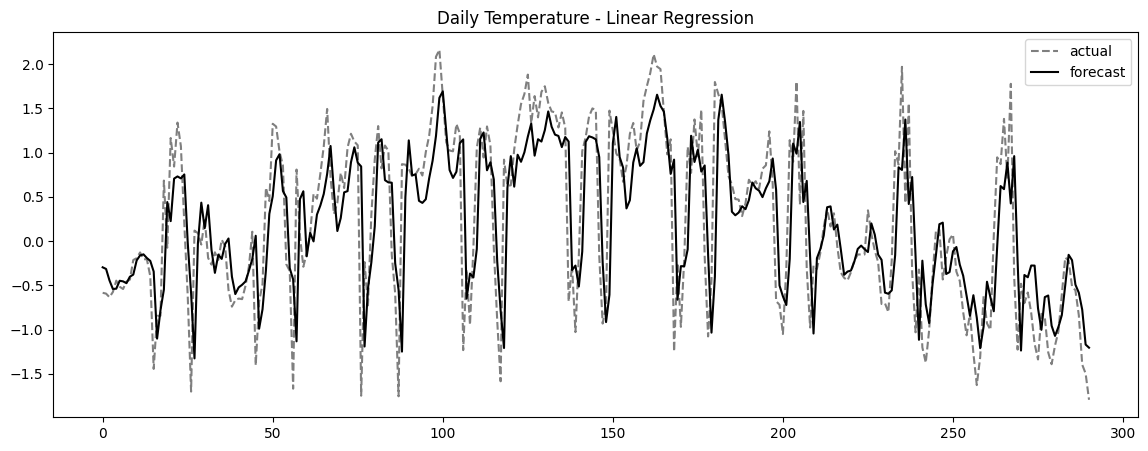

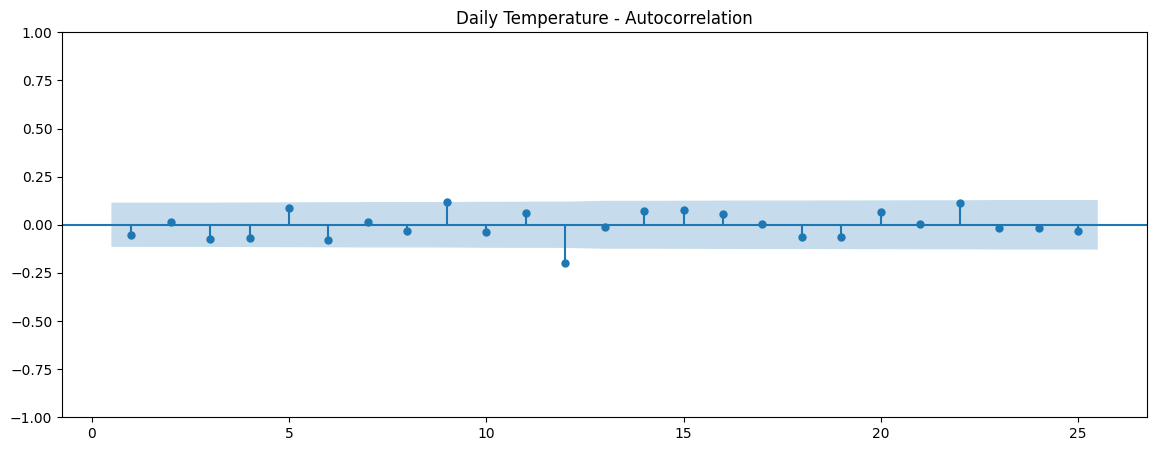

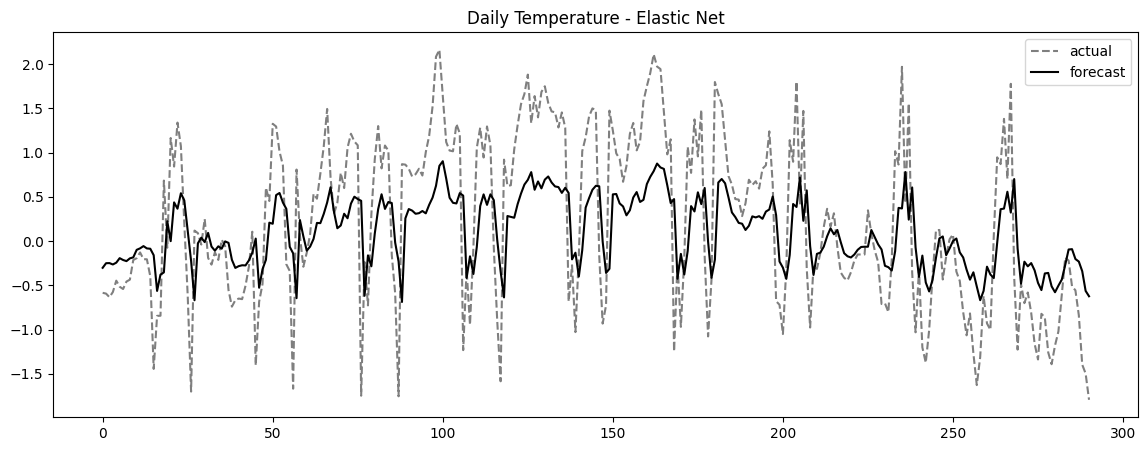

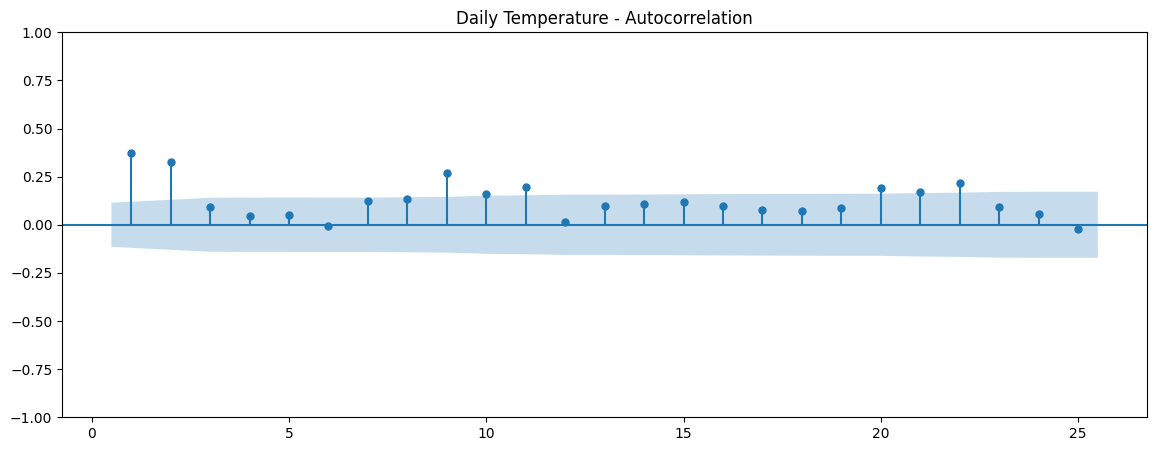

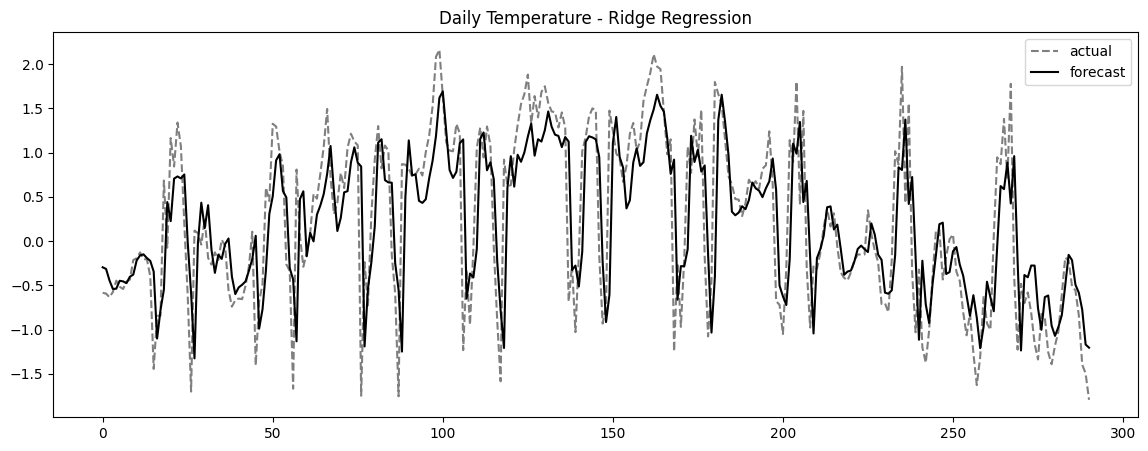

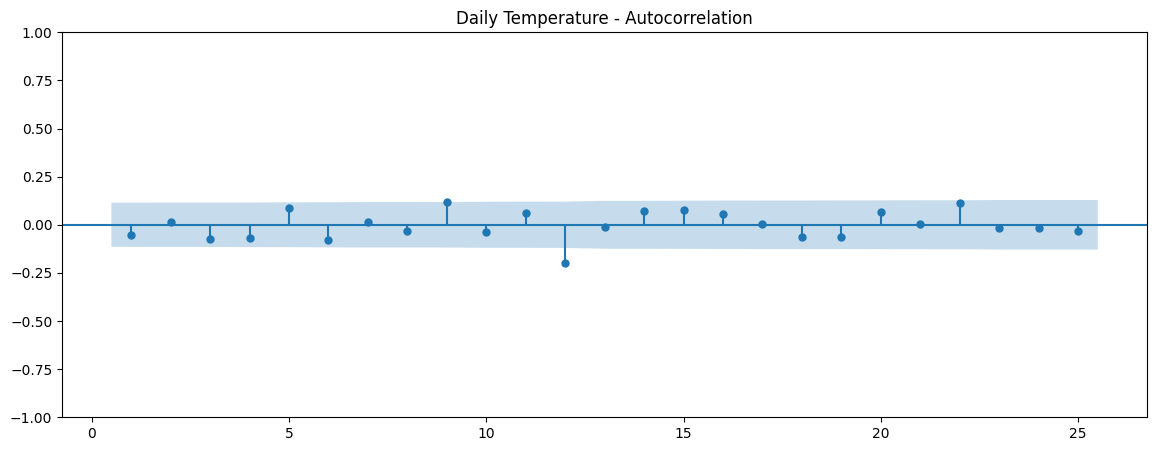

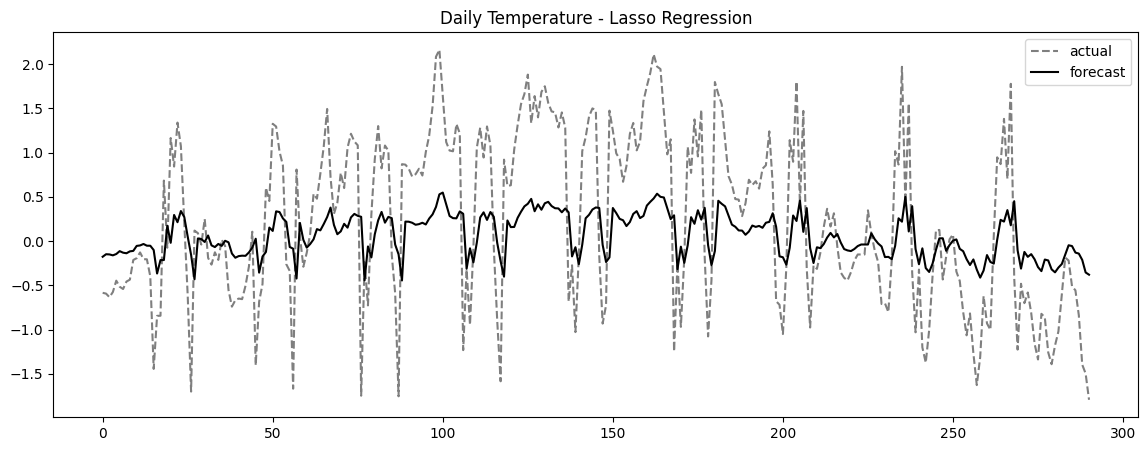

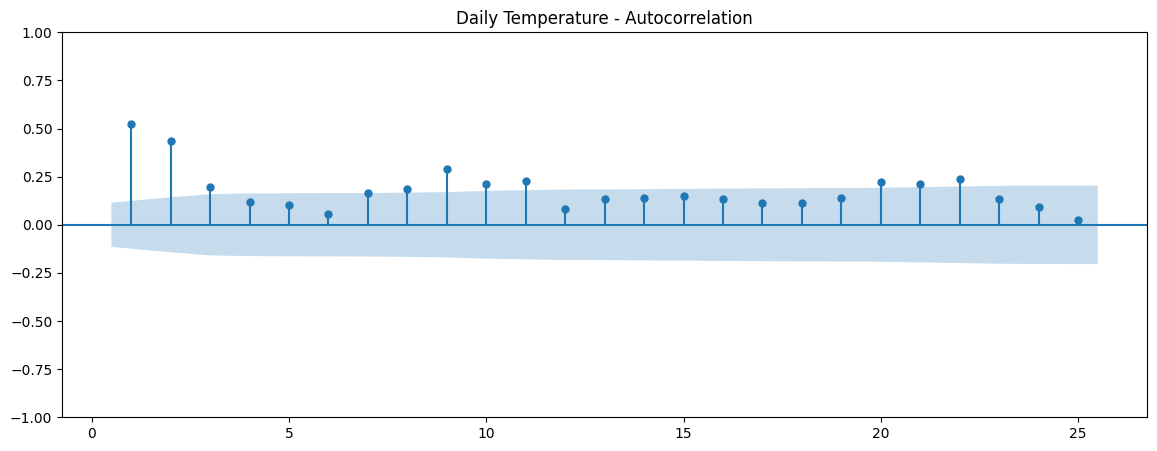

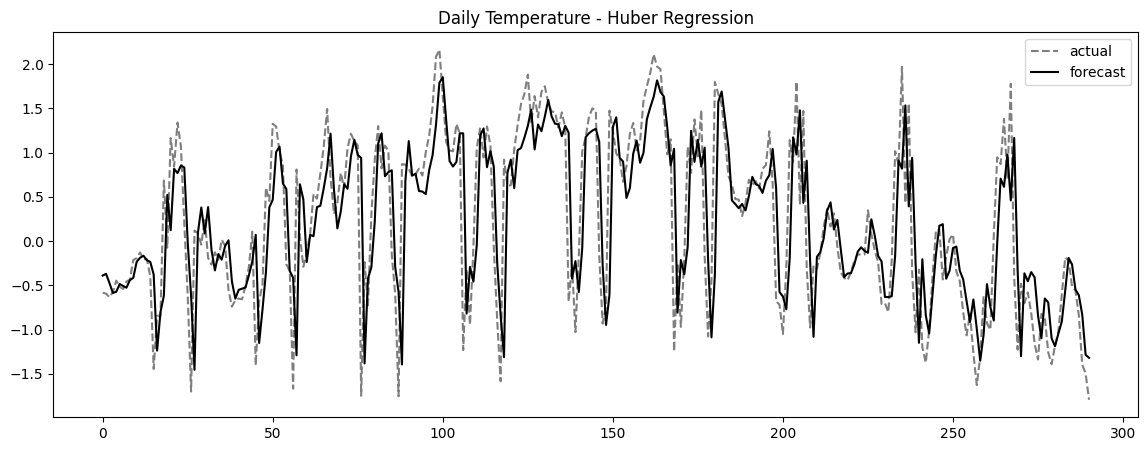

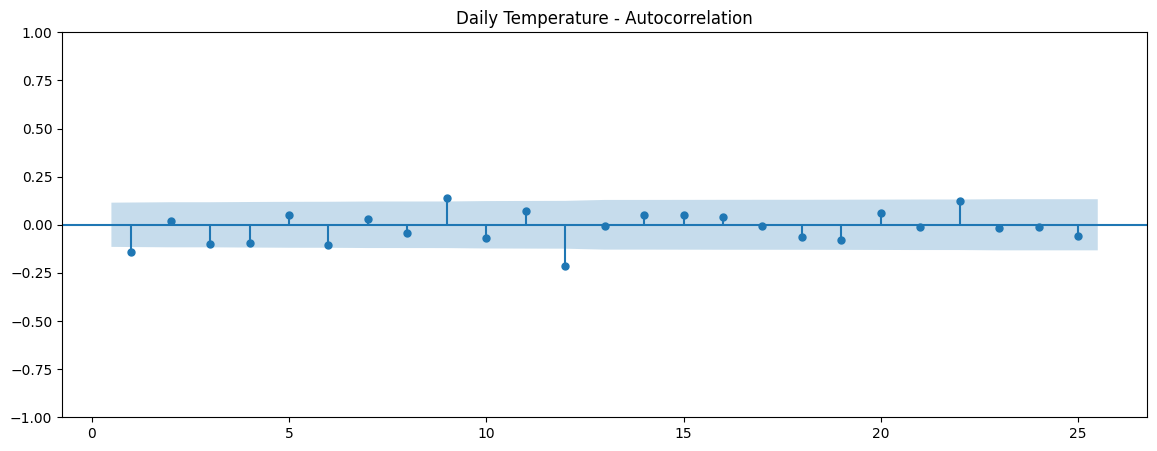

In [52]:

plot_results(cols, dw_results, 'Daily Temperature')


In [53]:

cols = ['Model Name', 'Model']
en_models = en_results.iloc[0:4][cols]

for row in en_models.iterrows():
    print(row[1][0])
    print(row[1][1].coef_)


Linear Regression
[ 0.02739136  0.02052173  0.03768302  0.06630472  0.01417452 -0.08727704
  0.02856578 -0.13640839  0.14165493  0.70683461]
Elastic Net
[0.         0.         0.         0.         0.         0.
 0.         0.         0.04077799 0.37835549]
Ridge Regression
[ 0.0273999   0.02054709  0.0377177   0.06625515  0.01414968 -0.08721396
  0.02844889 -0.13622568  0.14175768  0.7065417 ]
Lasso Regression
[0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.2536153]


In [54]:

en_10 = en_reg[['y', 'x_10']]

train_en10, test_en10 = split_data(en_10, test_split=0.10)
scaler_en10 = Standardize()
train_en10_s, test_en10_s = scaler_en.fit_transform(train_en10, test_en10)

en_10_results = train_different_models(train_en10_s, test_en10_s, regressors)

cols = ['Model Name', 'RMSE', 'MAPE', 'MASE']
en_10_results = pd.DataFrame(en_results)
en_10_results[cols].sort_values('MASE')


training Linear Regression ...
training Elastic Net ...
training Ridge Regression ...
training Lasso Regression ...
training Huber Regression ...


,Model Name,RMSE,MAPE,MASE
4,Huber Regression,0.431651,1.419527,0.525526
2,Ridge Regression,0.433192,1.586383,0.560450
0,Linear Regression,0.433747,1.583406,0.560989
1,Elastic Net,0.747657,1.822362,1.013425
3,Lasso Regression,0.834356,1.548537,1.108092


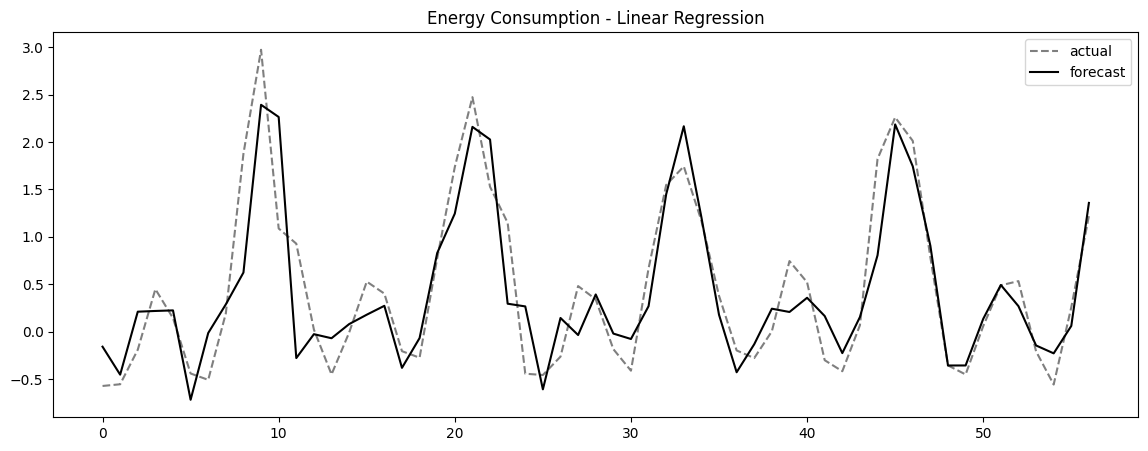

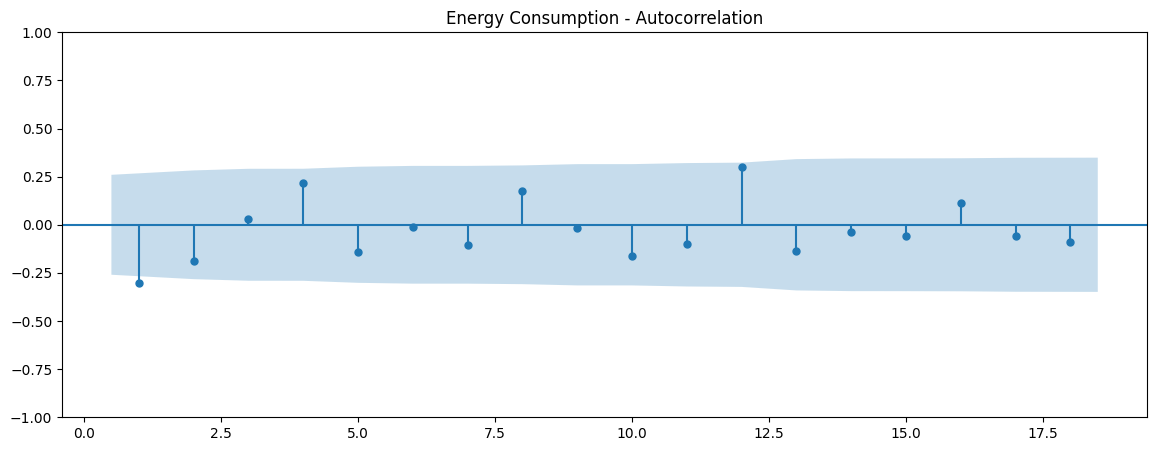

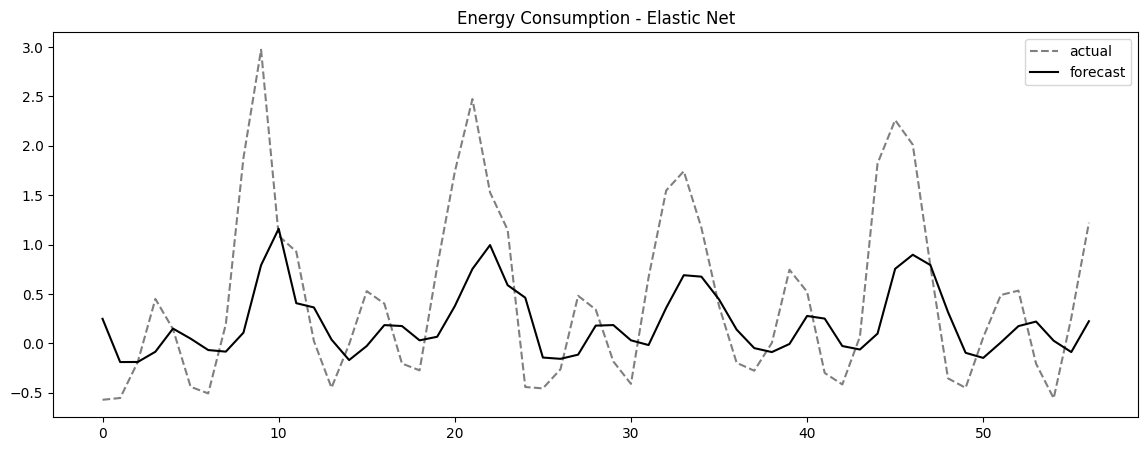

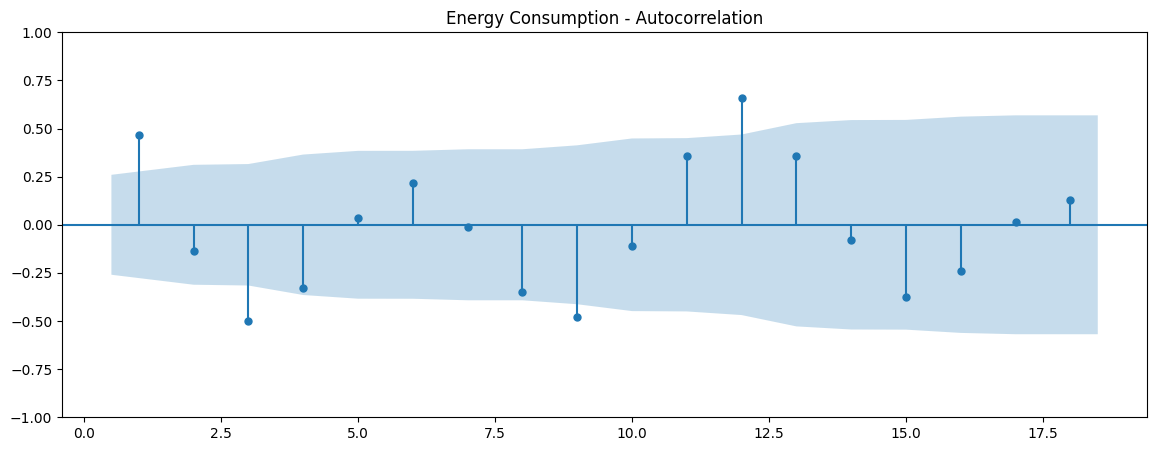

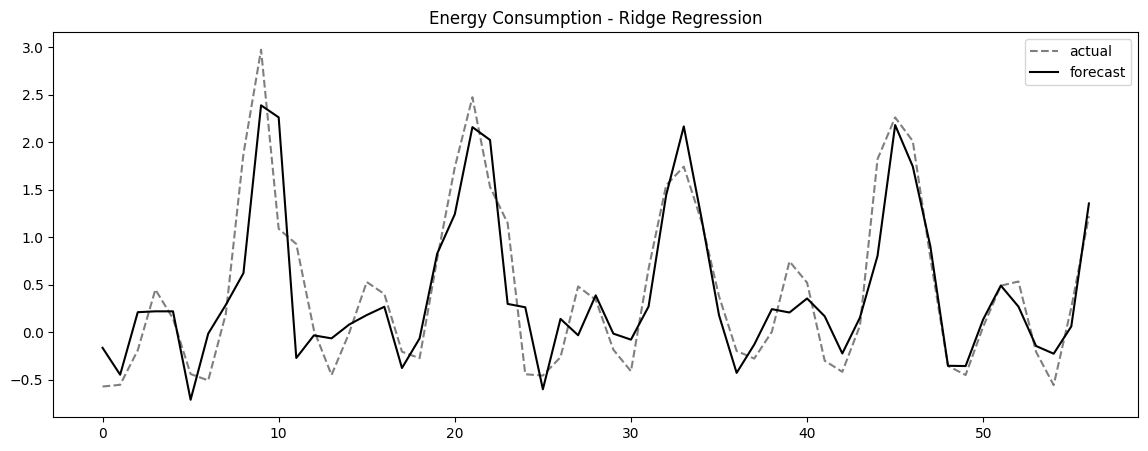

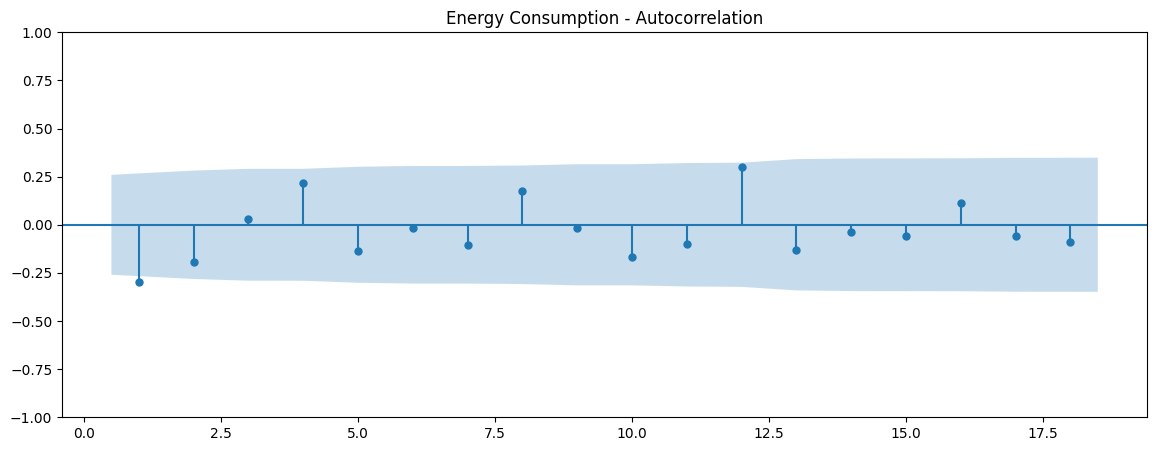

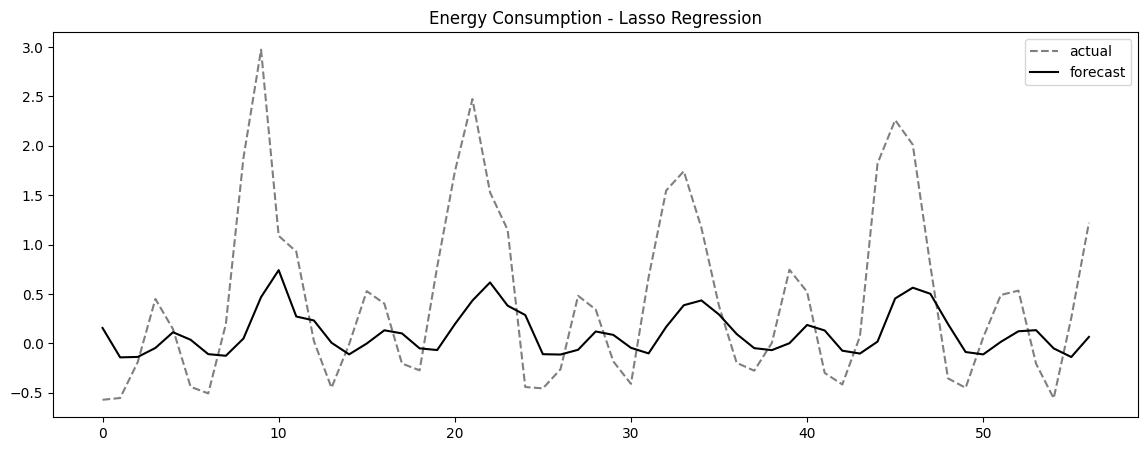

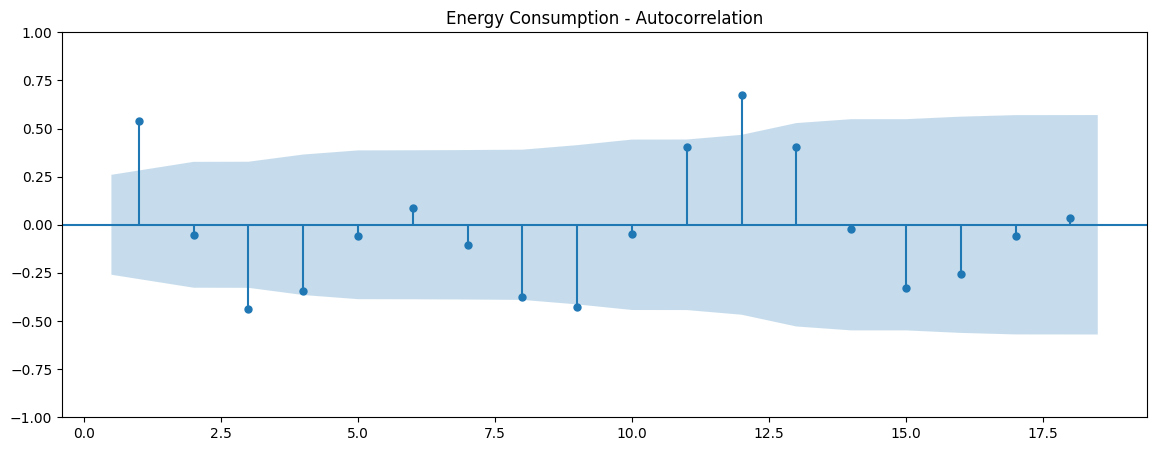

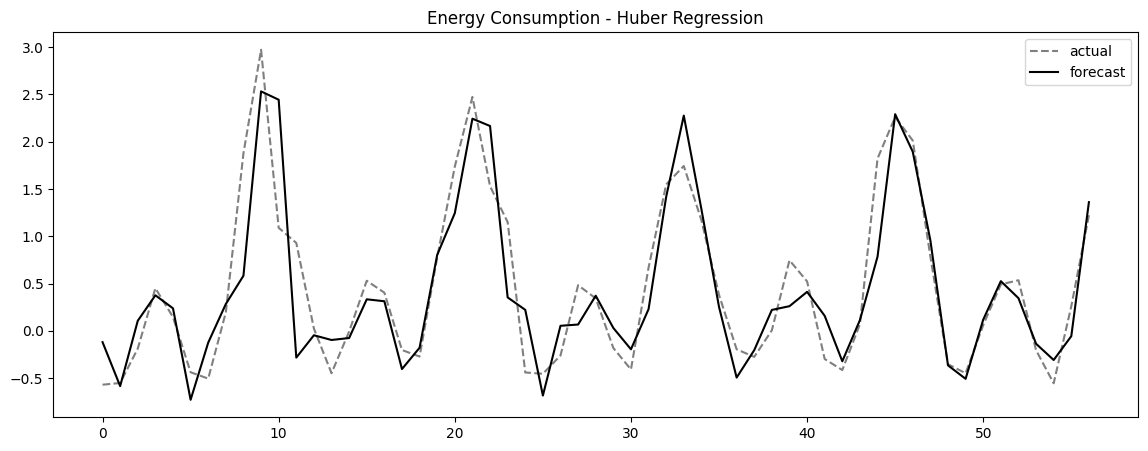

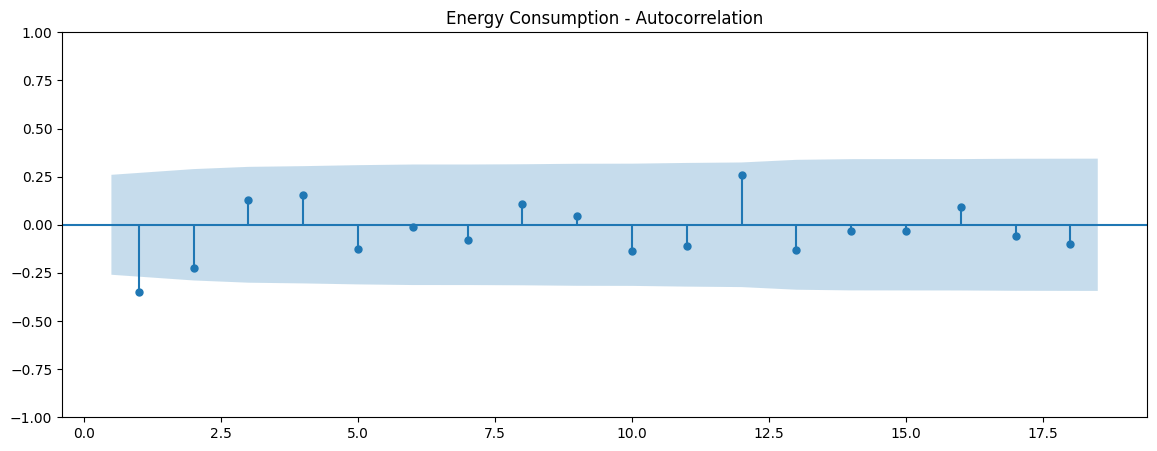

In [56]:
cols = ['yhat', 'resid', 'actual', 'Model Name']
plot_results(cols, en_10_results, 'Energy Consumption')


In [57]:

cols = ['Model Name', 'Model']
en_models = en_10_results.iloc[0:4][cols]

for row in en_models.iterrows():
    print(row[1][0])
    print(row[1][1].coef_)


Linear Regression
[0.75051783]
Elastic Net
[0.39987585]
Ridge Regression
[0.74979687]
Lasso Regression
[0.24955629]



## Silicon Data



## Multi-Step Forecasting using Linear Regression Models with Scikit-Learn
